| Field      | Information                         |
|------------|-------------------------------------|
| **Author** | Abdelaziz Nematallah                |
| **Date**   | 11/11/2024                           |
| **Desc**   | This notebook is to solve the third part of lab1 |
### Task3: Partial Known Plain-Text Analysis
#### Problem Analysis: 
* We are solving a partial known plain-text analysis problem
* this means that we know parts of the ciphertext, and its corresponding plaintext
* This should allow us to have a hint about the used key, or to fully compromise the key. 
* know lets analyse the given sentences in order to be able to get as much information as we can. 

### Description analysis: 
* we are using 96-Bit-long XOR Key
  * this indicates the length of the used key (96bit = 12 bytes), and the encryption algorithm(XOR)
* The Compression was done with the defaults options using linux zip command-line-tool (version 3.0)
  * now we can have common headers and common algorithm lets search about it and understand how it works then continue
  * I found that it uses constant algorithm called "**Deflate**" for compression, and the output will always start with consistent header which is (50 48 30 04)
  * so this is why our problem is partial known plaintext, because we know this header. 
* The file contains no comments: 
  * This simplifies the structure of  the file, so the analysis should be easier.
*   The task may not be solved in one iteration. Assuming a part of the key is known only, you
 can use zeroes for the missing bytes of the key. So if, for example, you are sure the last two
 bytes are 0xFF 0xFF, then the key 0x00 0x00 0x00 0x00 0x00 0x00 0x00
 0x00 0xFF 0xFFmaybeusedinafirst iteration. Think about why this fact is important
 for your analysis
  * This indicates that we can apply many iterations in order to reach the solution 

### What I am thinking about
* now we have the header and its corresponding result, so we can try to apply brute force maybe on the remaining parts of the key, to be ablr to get the key

### RealTime Trails Screenshots
* Here when printing the header of two different zip files, we got the same begining of the header which is "**504b 0304**"
* 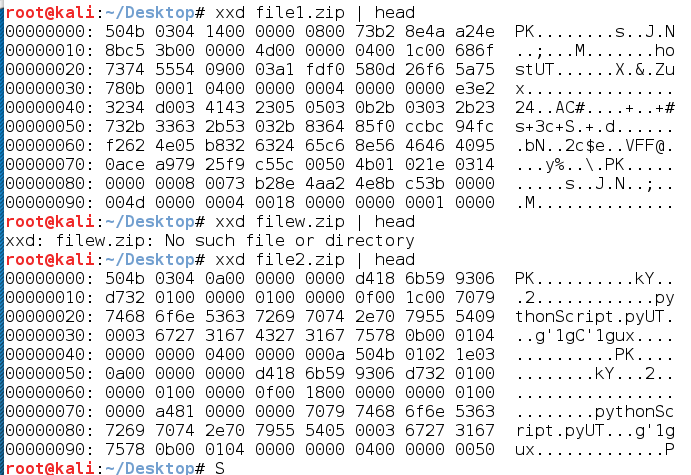
* and when I print the version of the used zip, I found it is also version 3, as stated in the problem description:
* 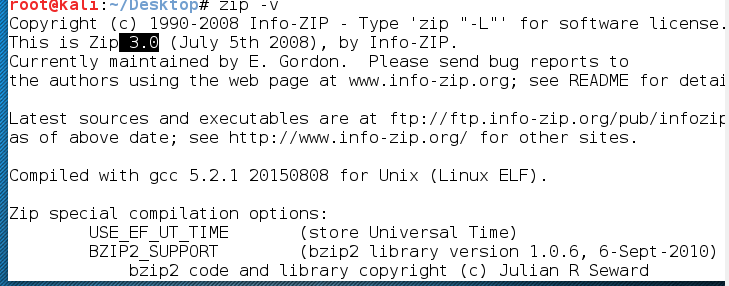
* now when I tried to print the body of different files after zipping them, I got different results:
* 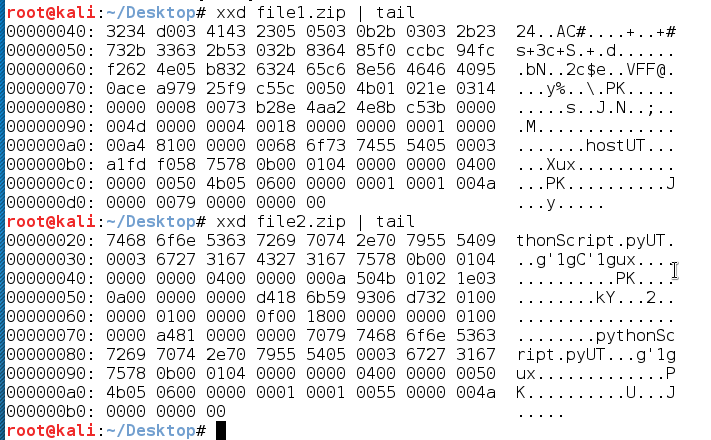

### Lets walk one step by another
1. Reading the header of the encrypted file

In [1]:
zipFilePath = './XOR.zip.crypt'

# open the file to be read as binary, and read the first 4 bytes as header. 
with open (zipFilePath, 'rb') as file: 
    headerBytes = file.read(10)

# print the header in hexadecimal
print('Header bytes: ', headerBytes.hex(),  )

Header bytes:  cc938c162f46d6b8f67d


2. now since we know the common header for any zip file which is **50 4B 03 04**
   * we can use this information to get first 4 bytes of the key using this method:
     * key = cipher xor plain

In [2]:
commonHeaderBytes = bytes.fromhex('504b0304')
encryptedHeader = bytes.fromhex(headerBytes.hex())

# now lets perform the xor
xorByte = bytearray()
for encByte, zipByte in zip(encryptedHeader, commonHeaderBytes):
    xorByte.append(encByte ^ zipByte)

# now lets print the result
print(xorByte.hex())

# now we have 

9cd88f12


* now we got 4 bytes out of the 12 key bytes
* so by using the last hint in the problem, we can pad our key with zeros, and try it as a first key, and then try to apply further analysis

In [3]:
key = '9cd88f12'+''.join('00' for i in range(8))
print(key)

9cd88f120000000000000000


* After I try to understand the header more, I found this useful link: 
* [PKZip explaination](https://users.cs.jmu.edu/buchhofp/forensics/formats/pkzip.html)
* and I found that the local file header should be as follow: 
  * 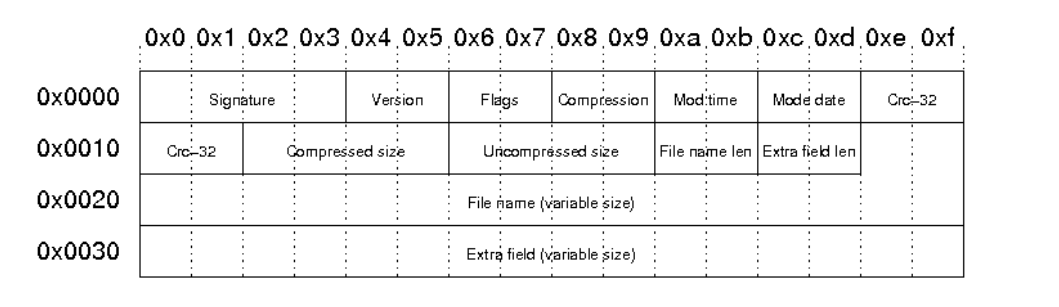
* so by applying analogy to what we have
  * our signature is '504b0304'
  * our version can be (v1 -> 0a00) (v2-> 1400) (v3->1e00)
  * our flags are 0000 because it is encrypted file
  * our compression method is 00 because it is the default method like mentioned in the problem
* so we get this: 
  * **504b0304xx0000000000xxxx**
* now we can apply bruteforce to find the key, we have 2^16 * 3 (the only 3 possible versions) which is a feasible computation.

### trying v1
* header: 504b03040a0000000000

In [4]:
commonHeaderBytes = bytes.fromhex('504b03040a0000000000')
encryptedHeader = bytes.fromhex(headerBytes.hex())

# now lets perform the xor
partialInitialKey = bytearray()
for encByte, zipByte in zip(encryptedHeader, commonHeaderBytes):
    partialInitialKey.append(encByte ^ zipByte)

# now lets print the result
print(partialInitialKey.hex())

# now we have 10 bytes of the key

9cd88f122546d6b8f67d


In [5]:
import itertools
import zipfile
import io

# Your partial key with the known part: '504b03040a0000000000'
# partialKey = bytearray.fromhex("9cd88f122546d6b8f67d")
partialKey = bytearray(partialInitialKey)

# The encrypted data you want to try to decrypt (read from the file)
with open("XOR.zip.crypt", "rb") as file:
    encrypted_data = file.read()

# Function to perform XOR decryption
def xor_decrypt(data, key):
    key_length = len(key)
    decryptedData = bytearray()
    for i in range(len(data)):
        decryptedData.append(data[i] ^ key[i % key_length])
    return bytes(decryptedData)

# Iterate over all possible values for the 2 unknown bytes (0x0000 to 0xFFFF)
counter = 1
possibleKeys = []
for b1, b2 in itertools.product(range(256), repeat=2):
    # Construct the full 12-byte key with the 2 unknown bytes
    fullKey = partialKey + bytearray([b1, b2])
    # print(fullKey)
    # Decrypt the data with the current key
    decryptedData = xor_decrypt(encrypted_data, fullKey)

    # Check if the decrypted data has a valid ZIP header
    if decryptedData.startswith(b"PK\x03\x04"):
      
        possibleKeys.append(fullKey)

        # now lets try to unzip the file, and get its content.
        # if this is a valid zip file, we will extract the content, otherwise, we need to try another key.  
        try:
            with zipfile.ZipFile(io.BytesIO(decryptedData)) as zip_file:
                # List the contents of the ZIP file to ensure it's valid
                fileList = zip_file.namelist()
                print(f"Correct key found: {fullKey.hex()}")
                print("Contents of the ZIP file:", fileList)

                # Save the successfully decrypted data to a file
                with open("decrypted_successful.zip", "wb") as outputFile:
                    outputFile.write(decryptedData)
                with open("XOR.key", "w") as keyFile:
                    keyFile.write(fullKey.hex())
                break
        except (zipfile.BadZipFile, zipfile.LargeZipFile):
            # If decompression fails, continue to the next key
            continue
            # possibleKeys.append(fullKey)
        # break
else:
    print("No valid key found.")

# just want to know how many of generated keys (2^16) can decrypt the header correctly
print(len(possibleKeys))

#! Remark: 
# we were lucky that we have found the key in the v1 approach, if we did not, we should try other versions which are v2 and v3


Correct key found: 9cd88f122546d6b8f67d6951
Contents of the ZIP file: ['README.md']
26962


## read me content
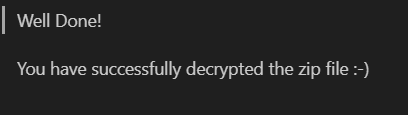